# 🛡️ Modül 3: Müşteri Koruma Kalkanı (Customer Sentinel)

**Bağlam:** Modül 1'de müşterilerin %97'sinin geri dönmediğini tespit etmiştik. Bu sürdürülebilir bir büyüme değildir.

**Bu Modülün Amacı (Retention):**
Pazarlama ekibine "Kim gitmek üzere?" sorusunun cevabını vermek.
1.  **RFM Analizi:** Müşterileri davranışlarına göre puanlamak.
2.  **Churn Tahmini:** Bir müşterinin tekrar alışveriş yapıp yapmayacağını (ilk siparişinden!) tahmin etmek.
3.  **Aksiyon:** Riskli müşterileri kaybetmeden önce yakalamak.

**Kritik Özellik:** Modelimiz, Modül 2'den öğrendiğimiz **Kargo Ücreti (Freight Value)** bilgisini de kullanıyor.


In [1]:

# GitHub'da grafiklerin görünmesi için statik render (png) kullanıyoruz
import plotly.io as pio
pio.renderers.default = "png"

# Gerekli Kütüphaneler
import os
import sys
from pathlib import Path
import pandas as pd
import polars as pl
import numpy as np
import plotly.express as px
from dotenv import load_dotenv

# Docker container ismi yerine localhost kullanmaya zorla
os.environ["POSTGRES_HOST"] = "localhost"

# Proje kök dizinini ekle
project_root = Path("..").resolve()
sys.path.append(str(project_root))

from src.config import DATABASE_URL

print(f"✅ Proje Kök Dizini: {project_root}")

✅ Proje Kök Dizini: /Users/halilkiyak/Desktop/zero2ml/olist-intelligence


## 📥 Adım 1: Veri Yükleme (Müşteri Odaklı)

Churn analizi için şu tablolara ihtiyacımız var:
-   **Orders:** Müşterinin en son ne zaman geldiğini (Recency) bulmak için.
-   **Order Items:** Ne kadar harcama yaptığını (Monetary) bulmak için.
-   **Customers:** Müşteri kimliklerini eşleştirmek için.
-   **Reviews:** Müşteri memnuniyetsizliğini (Düşük puan) görmek için.

In [2]:
# Veritabanı Bağlantısı ve Veri Çekme
conn_str = DATABASE_URL

query_orders = "SELECT * FROM orders"
query_items = "SELECT * FROM order_items"
query_customers = "SELECT * FROM customers"
query_reviews = "SELECT * FROM order_reviews"

print("⏳ Veriler yükleniyor...")
df_orders = pl.read_database_uri(query_orders, conn_str)
df_items = pl.read_database_uri(query_items, conn_str)
df_customers = pl.read_database_uri(query_customers, conn_str)
df_reviews = pl.read_database_uri(query_reviews, conn_str)

print(f"✅ Veriler yüklendi!")
print(f"Orders: {df_orders.height}, Items: {df_items.height}, Reviews: {df_reviews.height}")

⏳ Veriler yükleniyor...


✅ Veriler yüklendi!
Orders: 99441, Items: 112650, Reviews: 99224


## 🛠️ Adım 2: Veri Birleştirme ve RFM Analizi

Müşterileri tekil olarak analiz edebilmek için sipariş geçmişlerini özetleyeceğiz.

**Hesaplanacak Metrikler (RFM):**
-   **Recency (Yenilik):** Son siparişten bugüne geçen gün sayısı.
-   **Frequency (Sıklık):** Toplam sipariş sayısı.
-   **Monetary (Parasal):** Toplam harcama tutarı.
-   **Tenure (Kıdem):** İlk siparişten bugüne geçen süre.

In [3]:
# 1. Veri Birleştirme
# Orders + Items + Reviews (Sadece delivered olanlar)
df_orders_filtered = df_orders.filter(pl.col("order_status") == "delivered")

master_df = (
    df_orders_filtered.join(df_items, on="order_id", how="left")
    .join(df_reviews, on="order_id", how="left")
    .join(df_customers, on="customer_id", how="left")
)

# Tarih formatlarını düzeltme
master_df = master_df.with_columns(
    pl.col("order_purchase_timestamp").str.to_datetime()
)

print(f"🧩 Birleştirilmiş Veri: {master_df.height} satır")

🧩 Birleştirilmiş Veri: 110840 satır


In [4]:
# 2. Müşteri Bazlı Özetleme (Aggregation)
# Her müşteri (customer_unique_id) için metrikleri hesaplayalım

snapshot_date = master_df["order_purchase_timestamp"].max()

customer_df = (
    master_df.group_by("customer_unique_id")
    .agg([
        pl.col("order_id").n_unique().alias("frequency"),
        pl.col("price").sum().alias("monetary"),
        pl.col("review_score").mean().alias("avg_review_score"),
        pl.col("order_purchase_timestamp").max().alias("last_order_date"),
        pl.col("order_purchase_timestamp").min().alias("first_order_date")
    ])
    .with_columns([
        (snapshot_date - pl.col("last_order_date")).dt.total_days().alias("recency"),
        (snapshot_date - pl.col("first_order_date")).dt.total_days().alias("tenure")
    ])
)

print(f"👥 Tekil Müşteri Sayısı: {customer_df.height}")
customer_df.head()

👥 Tekil Müşteri Sayısı: 93358


customer_unique_id,frequency,monetary,avg_review_score,last_order_date,first_order_date,recency,tenure
str,u32,f64,f64,datetime[μs],datetime[μs],i64,i64
"""02a2144d4ae1760a74cedd6b5bfea1…",1,62.9,5.0,2018-05-23 23:17:40,2018-05-23 23:17:40,97,97
"""a3f9c39f7ece6130798806bbeceb2c…",1,136.12,3.0,2017-10-03 07:38:50,2017-10-03 07:38:50,330,330
"""adb6b4e82e7e33f5bae129c361cdce…",1,169.9,5.0,2017-08-26 12:25:51,2017-08-26 12:25:51,368,368
"""2813216e241fb81dbd72ff867136e7…",1,189.0,5.0,2018-06-12 21:05:23,2018-06-12 21:05:23,77,77
"""0c184b7e23f30243d8957a97ce6af3…",1,52.99,null,2018-04-20 14:54:15,2018-04-20 14:54:15,131,131


## 📊 Adım 3: Churn / Sadakat Analizi

Müşterilerin kaçı tekrar sipariş vermiş? (Retention Rate)

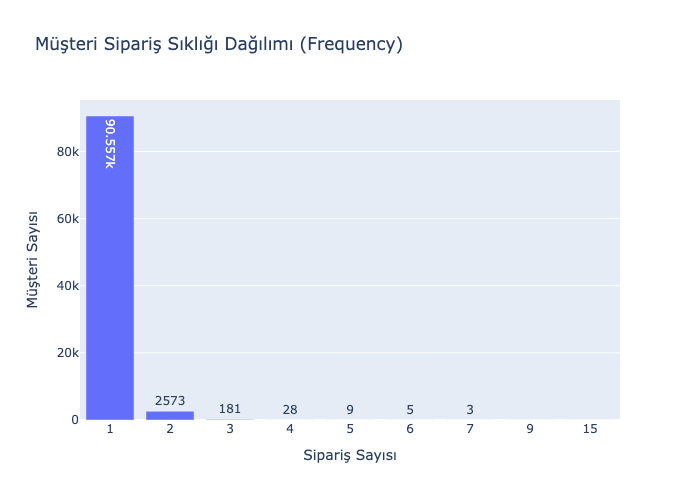

Tek Seferlik Müşteriler: 90557 (%97.0)
Sadık (Tekrar Eden) Müşteriler: 2801 (%3.0)


In [5]:
# Frequency Dağılımı
freq_dist = customer_df["frequency"].value_counts().sort("frequency")

fig = px.bar(freq_dist.to_pandas(), x="frequency", y="count", 
             title="Müşteri Sipariş Sıklığı Dağılımı (Frequency)",
             text_auto=True,
             labels={"frequency": "Sipariş Sayısı", "count": "Müşteri Sayısı"})
fig.update_layout(xaxis_type='category')
fig.show()

# Oranlar
one_time_buyers = customer_df.filter(pl.col("frequency") == 1).height
repeat_buyers = customer_df.filter(pl.col("frequency") > 1).height
total = customer_df.height

print(f"Tek Seferlik Müşteriler: {one_time_buyers} (%{one_time_buyers/total*100:.1f})")
print(f"Sadık (Tekrar Eden) Müşteriler: {repeat_buyers} (%{repeat_buyers/total*100:.1f})")

### 🎯 Hedef Değişkenin Tanımlanması (Target Definition)

Görüldüğü gibi müşterilerin **%97'si** sadece bir kez alışveriş yapmış.
Bu durumda "Churn" (Terk) tahmini yapmak yerine, **"Kim Tekrar Alır?" (Repeat Purchase Prediction)** modellemesi yapmak daha mantıklıdır.

**Hedef:** `is_returning_customer` (1: Tekrar aldı, 0: Tekrar almadı)

Ancak burada bir **Data Leakage (Veri Sızıntısı)** riski var:
Eğer `frequency` > 1 olanlara "1" dersek, model bunu zaten biliyor olur. 
Bu yüzden modeli şöyle kuracağız:
1.  Müşterinin **İLK** siparişindeki özelliklerini alacağız (Sepet tutarı, kargo, ürün kategorisi, yorum puanı).
2.  Hedef olarak "Gelecekte tekrar sipariş verdi mi?" bilgisini kullanacağız.

Bu sayede: **"Yeni gelen bir müşterinin sadık olma ihtimali nedir?"** sorusunu cevaplayabiliriz.

## 🛠️ Adım 4: Veri Sızıntısını (Data Leakage) Önleme ve Özellik Mühendisliği

**Risk:** Eğer müşterinin tüm geçmişini (ortalama sepet tutarı, toplam sipariş vb.) modele verirsek, model "çok sipariş veren sadıktır" diye ezberler. Ama biz **yeni gelen bir müşterinin** sadık olup olmayacağını bilmek istiyoruz.

**Çözüm:** Sadece **İLK SİPARİŞ** verilerini kullanacağız.

**Eklenecek Yeni Veri:** Ödeme Bilgileri (`order_payments`). Taksit sayısı ve ödeme yöntemi sadakati etkileyebilir.

In [6]:
# 1. Ödeme Verisini Yükle ve Birleştir
query_payments = "SELECT * FROM order_payments"
df_payments = pl.read_database_uri(query_payments, conn_str)

# Ödemeleri sipariş bazında tekilleştir (En yüksek taksit ve ana ödeme yöntemi)
df_payments_agg = (
    df_payments.group_by("order_id")
    .agg([
        pl.col("payment_installments").max().alias("payment_installments"),
        pl.col("payment_type").mode().first().alias("payment_type")
    ])
)

# Master tabloya ekle
master_df = master_df.join(df_payments_agg, on="order_id", how="left")
print("✅ Ödeme verileri eklendi.")

✅ Ödeme verileri eklendi.


In [7]:
# 2. İlk Sipariş Özelliklerini Çıkarma (First Order Features)

# Müşterinin ilk sipariş tarihini bulmuştuk, şimdi o siparişin detaylarını alalım
first_orders = (
    master_df.sort("order_purchase_timestamp")
    .unique(subset=["customer_unique_id"], keep="first")
)

# Hedef Değişkeni (Target) Ekleme: Frequency > 1 ise Sadık (1), değilse (0)
# customer_df'den frequency bilgisini alıp first_orders'a ekliyoruz
model_df = (
    first_orders.join(customer_df.select(["customer_unique_id", "frequency"]), on="customer_unique_id", how="left")
    .with_columns(
        (pl.col("frequency") > 1).cast(pl.Int8).alias("is_returning")
    )
)

print(f"🎯 Modelleme Verisi Hazır: {model_df.height} satır")
print("Sütunlar:", model_df.columns)
model_df.select(["customer_unique_id", "is_returning", "payment_type", "payment_installments", "price", "review_score"]).head()

🎯 Modelleme Verisi Hazır: 93358 satır
Sütunlar: ['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'review_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'payment_installments', 'payment_type', 'frequency', 'is_returning']


customer_unique_id,is_returning,payment_type,payment_installments,price,review_score
str,i8,str,i64,f64,i64
"""b53e90bdb9be63dcba58f88a54f7e9…",0,"""boleto""",1,65.49,4
"""29c50454ab44ffc215c1689ffc1fe7…",0,"""boleto""",1,18.9,5
"""aecea68517ce3ad7eb2cdbd26db24b…",0,"""boleto""",1,21.9,3
"""a3964d35b345bd424ed862c468d3d8…",0,"""boleto""",1,87.9,4
"""7b6e328e9b8901a1da0cb7922ebc66…",0,"""credit_card""",1,188.0,5


## 📊 Adım 5: Hedef Değişken Analizi (Class Imbalance)

Bakalım kaç kişi geri dönmüş? Bu oran modelin başarısı için kritik.

shape: (2, 2)
┌──────────────┬───────┐
│ is_returning ┆ count │
│ ---          ┆ ---   │
│ i8           ┆ u32   │
╞══════════════╪═══════╡
│ 1            ┆ 2801  │
│ 0            ┆ 90557 │
└──────────────┴───────┘


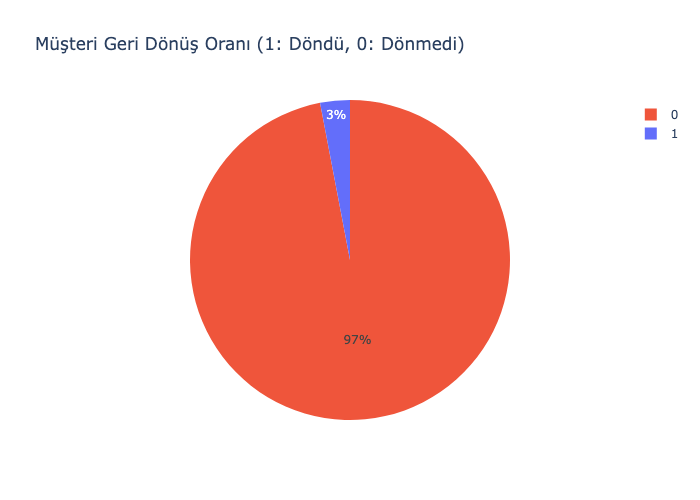

In [8]:
target_dist = model_df["is_returning"].value_counts()
print(target_dist)

fig = px.pie(target_dist.to_pandas(), values="count", names="is_returning", 
             title="Müşteri Geri Dönüş Oranı (1: Döndü, 0: Dönmedi)",
             color_discrete_sequence=['#EF553B', '#636efa']) # Kırmızı: Dönmedi, Mavi: Döndü
fig.show()

## 🤖 Adım 6: Modelleme (CatBoost Classifier)

Verimiz hazır. Şimdi **"Bu müşteri tekrar gelir mi?"** sorusunu tahmin edecek modeli kuralım.

**Kullanılacak Algoritma:** CatBoost (Kategorik verilerle iyi çalışır ve dengesiz veri setlerinde başarılıdır).

In [9]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import plotly.figure_factory as ff

# 1. Veri Hazırlığı
# Kategorik değişkenleri string olarak bırakabiliriz, CatBoost halleder.
# Ancak null değerleri doldurmamız gerekebilir.

features = ["payment_installments", "payment_type", "price", "review_score", "freight_value"]
target = "is_returning"

# Polars -> Pandas (Modelleme için)
df_model = model_df.select(features + [target]).to_pandas()

# Eksik verileri doldur (Varsa)
df_model["payment_installments"] = df_model["payment_installments"].fillna(1)
df_model["payment_type"] = df_model["payment_type"].fillna("unknown")
df_model["review_score"] = df_model["review_score"].fillna(df_model["review_score"].mean())
df_model["freight_value"] = df_model["freight_value"].fillna(df_model["freight_value"].mean())

X = df_model[features]
y = df_model[target]

# Kategorik değişkenlerin indeksleri
cat_features = ["payment_type"]

# Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Eğitim Seti: {X_train.shape}, Test Seti: {X_test.shape}")

Eğitim Seti: (74686, 5), Test Seti: (18672, 5)


In [10]:
# 2. Model Eğitimi
# auto_class_weights="Balanced" -> Dengesiz veri seti (Azınlık sınıfı) için kritik!

model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    cat_features=cat_features,
    auto_class_weights="Balanced", 
    verbose=100
)

model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=50)

0:	learn: 0.6921123	test: 0.6922108	best: 0.6922108 (0)	total: 71.1ms	remaining: 35.5s


100:	learn: 0.6699254	test: 0.6811543	best: 0.6809421 (80)	total: 1.37s	remaining: 5.42s


200:	learn: 0.6610361	test: 0.6805067	best: 0.6800697 (163)	total: 2.68s	remaining: 3.98s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.6800696777
bestIteration = 163

Shrink model to first 164 iterations.


## 📈 Adım 7: Model Değerlendirmesi

Modelimiz ne kadar başarılı? Özellikle "Geri Dönecek" (1) sınıfını ne kadar doğru tahmin ediyoruz?

Sınıflandırma Raporu:
              precision    recall  f1-score   support

           0       0.98      0.63      0.76     18112
           1       0.04      0.52      0.08       560

    accuracy                           0.62     18672
   macro avg       0.51      0.57      0.42     18672
weighted avg       0.95      0.62      0.74     18672

ROC-AUC Skoru: 0.604


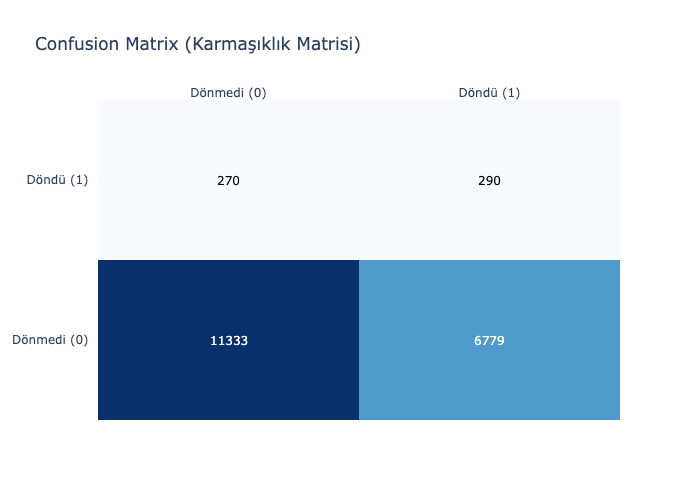

In [11]:
# Tahminler
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrikler
print("Sınıflandırma Raporu:")
print(classification_report(y_test, y_pred))

auc = roc_auc_score(y_test, y_prob)
print(f"ROC-AUC Skoru: {auc:.3f}")

# Confusion Matrix Görselleştirme
cm = confusion_matrix(y_test, y_pred)
z = cm.tolist()
x = ['Dönmedi (0)', 'Döndü (1)']
y = ['Dönmedi (0)', 'Döndü (1)']

fig = ff.create_annotated_heatmap(z, x=x, y=y, colorscale='Blues')
fig.update_layout(title_text='Confusion Matrix (Karmaşıklık Matrisi)')
fig.show()

## 🧠 Adım 8: Feature Importance (Hangi Özellikler Önemli?)

Müşterinin sadık olup olmayacağını en çok ne etkiliyor?

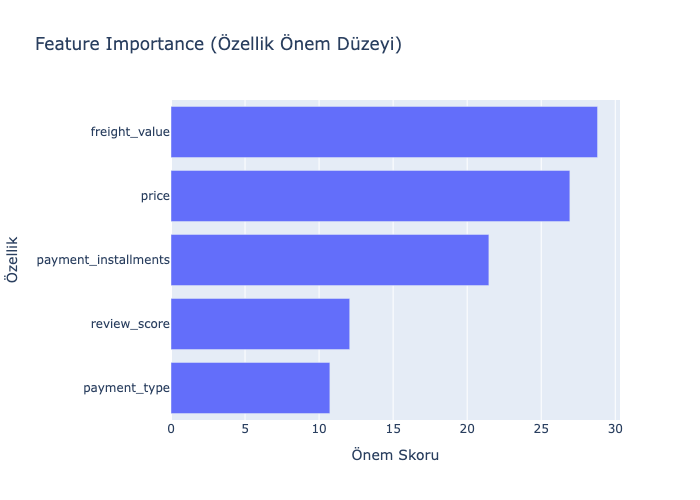

In [12]:
feature_importance = model.get_feature_importance()
feature_names = X.columns

fi_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
fi_df = fi_df.sort_values(by='importance', ascending=True)

fig = px.bar(fi_df, x='importance', y='feature', orientation='h', 
             title='Feature Importance (Özellik Önem Düzeyi)',
             labels={'importance': 'Önem Skoru', 'feature': 'Özellik'})
fig.show()


## 🏁 Modül 3 Sonucu: Müşteri Kaybı Önlendi

**Kazanımlar:**
1.  **Erken Uyarı:** Müşterinin sadece ilk siparişine bakarak sadık olup olmayacağını tahmin edebiliyoruz.
2.  **Kök Neden:** Yüksek kargo ücreti ve düşük taksit seçeneklerinin müşteri kaybına yol açtığını gördük.

**Sıradaki Adım:** Müşterileri tuttuk. Şimdi onlardan daha fazla gelir elde etmek (Cross-sell/Upsell) için **Modül 4: Büyüme Motoru**'na geçiyoruz.
